<a href="https://colab.research.google.com/github/ShanmukhaManoj11/DL_experiments/blob/master/pytorch_SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.nn.init as init

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
import itertools
from math import sqrt
import xml.etree.ElementTree as ET

# Data Utils

## VOC dataset configuration

In [ ]:
voc={
    'image_size': 300, # input image size
    'feature_map_sizes': [38,19,10,5,3,1], # size of feature maps used for detections
    'aspect_ratios': [[2],[2,3],[2,3],[2,3],[2],[2]], # aspect ratio of default boxes for each feature map, [a,b] => aspect ratios of 1, a, 1/a, 1/b are included
    'scales': [0.1,0.2,0.37,0.54,0.71,0.88,1.05], # scales of boxes for each feature map used, len(scales) = number of feature maps + 1, as at aspect ratio 1, 2 default boxes of scales s_k and sqrt(s_k*s_<k+1>) are included
    'name': 'VOC',
    'classes': {
        'aeroplane':1, 'bicycle':2, 'bird':3, 'boat':4, 'bottle':5, 'bus':6, 'car':7, 'cat':8, 'chair':9, 'cow':10,
        'diningtable':11, 'dog':12, 'horse':13, 'motorbike':14, 'person':15, 'pottedplant':16, 'sheep':17, 'sofa':18, 'train':19, 'tvmonitor':20
    }
}

VOC07_BASE_DIR='drive/My Drive/Colab/VOC2007/'
VOC07_TRAIN_IMAGES_DIR='trainval/JPEGImages/'
VOC07_TRAIN_ANNOTATIONS_DIR='trainval/Annotations/'

VOC12_BASE_DIR='drive/My drive/Colab/VOC2012/'
VOC12_TRAIN_IMAGES_DIR='JPEGImages/'
VOC12_TRAIN_ANNOTATIONS_DIR='Annotations/'

In [ ]:
def parse_voc_annotation_xml(annotation_xml):
  #####################################################################################################################################
  # @ parse annotation xml and output list of bounding boxes                                                                          #
  # @ [[xmin1, ymin1, xmax1, ymax1, class_id1], [xmin2, ymin2, xmax2, ymax2, class_id2], ...]                                         #
  #####################################################################################################################################
  annotation=[]
  root=ET.parse(annotation_xml).getroot()
  size=root.find('size')
  width=int(size.find('width').text)
  height=int(size.find('height').text)
  for obj in root.iter('object'):
    name=obj.find('name').text.lower().strip()
    bbox=obj.find('bndbox')
    xmin=int(bbox.find('xmin').text)/width
    ymin=int(bbox.find('ymin').text)/height
    xmax=int(bbox.find('xmax').text)/width
    ymax=int(bbox.find('ymax').text)/height
    annotation.append([xmin, ymin, xmax, ymax, voc['classes'][name]])
  return annotation

def get_default_boxes(config):
  #####################################################################################################################################
  # @ get default boxes for SSD network given feature map size, aspect ratios, scales and input image size                            #
  # returns a tensor of shape [n_priors, 4] - each row is of form [cx, cy, width, height] relative to image size                      #
  # n_priors=8732=(38^2 * 4 + 19^2 *6 + 10^2 * 6 + 5^2 * 6 + 3^2 * 4 + 1^2 * 4)                                                       #
  #   [38,19,10,5,3,1] are feature map scales used for predictions at multiple scales                                                 #
  #   [4,6,6,6,4,4] number of boxes per feature map used for predictions                                                              #
  #####################################################################################################################################
  image_size=config['image_size']
  feature_map_sizes=config['feature_map_sizes']
  aspect_ratios=config['aspect_ratios']
  scales=config['scales']
  default_boxes=[]
  for k, fs in enumerate(feature_map_sizes):
    for i, j in itertools.product(range(fs),repeat=2):
      cx, cy = (j+0.5)/fs, (i+0.5)/fs
      
      s_k=scales[k]
      default_boxes.append([cx,cy,s_k,s_k])
      
      s_kp1=sqrt(s_k * scales[k+1])
      default_boxes.append([cx,cy,s_kp1,s_kp1])
      
      for ar in aspect_ratios[k]:
        default_boxes.append([cx,cy,s_k*sqrt(ar),s_k/sqrt(ar)])
        default_boxes.append([cx,cy,s_k/sqrt(ar),s_k*sqrt(ar)])
  
  default_boxes=torch.Tensor(default_boxes).clamp_(0,1)
  return default_boxes

In [ ]:
default_boxes=get_default_boxes(voc)
print(default_boxes.shape)

torch.Size([8732, 4])


## VOC Dataset

In [ ]:
class VOCDataset(data.Dataset):
  def __init__(self, root, image_dir, annotation_dir, image_size=300, transforms=None):
    super(VOCDataset,self).__init__()
    self.root = root
    self.image_dir = image_dir
    self.annotation_dir = annotation_dir
    self.images = os.listdir(self.root+self.image_dir)
    self.image_size = image_size
    self.transforms = transforms
  
  def __len__(self):
    return len(self.images)
    
  def __getitem__(self, i):
    image = self.read_image(i)
    gt_labels = np.array(self.read_annotation(i))
    if self.transforms is not None:
      boxes = gt_labels[:,:-1]
      labels = gt_labels[:,-1]
      image, boxes, labels=self.transforms(image, boxes*300, labels)
      gt_labels = np.concatenate((boxes/300, np.expand_dims(labels,1)), 1)
    return torch.Tensor(image.copy()).permute(2,0,1), torch.Tensor(gt_labels)
  
  def read_image(self, i):
    image = cv2.imread(self.root+self.image_dir+self.images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = cv2.resize(image, (self.image_size,self.image_size)) 
    # TO-DO: try mean, std normalization
    image /= 255.0
    return image
  
  def read_annotation(self, i):
    image_id = self.images[i][:-4]
    annotation_xml = self.root+self.annotation_dir+image_id+'.xml'
    gt_labels=parse_voc_annotation_xml(annotation_xml)
    return gt_labels

def voc_batch_collate(batch):
  #####################################################################################################################################
  # @ collate fn for dealing with batches with different sized annotations fpr data loader                                            #
  # input:                                                                                                                            #
  #   1. batch: list of tuple of image and annotation tensors                                                                         #
  # outut:                                                                                                                            #
  #   1. imgs: stacked batch of images of shape [batch_size, C, H, W]                                                                 #
  #   2. targets: list of annotation tensors                                                                                          #
  #####################################################################################################################################
  imgs,targets=[],[]
  for sample in batch:
    imgs.append(sample[0])
    targets.append(sample[1])
  return torch.stack(imgs,0), targets

## Dataset test

In [ ]:
def show_image(ax, image, annotations=[], colors=[], class_list=[]):
  image_copy=image.copy()
  if annotations!=[] and len(colors)==len(annotations):
    for i, annotation in enumerate(annotations):
      for a in annotation:
        cv2.rectangle(image_copy, (int(a[0]), int(a[1])), (int(a[2]), int(a[3])), colors[i], 1)
        if len(a)==5 and class_list!=[]:
          if int(a[1])-6>0:
            cv2.putText(image_copy, class_list[int(a[4])-1], (int(a[0]), int(a[1])-2), cv2.FONT_HERSHEY_SIMPLEX, 0.3, colors[i], 1)
          else:
            cv2.putText(image_copy, class_list[int(a[4])-1], (int(a[0]), int(a[1])+5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, colors[i], 1)
  ax.imshow(image_copy)

In [ ]:
voc_dataset=VOCDataset(VOC07_BASE_DIR, VOC07_TRAIN_IMAGES_DIR, VOC07_TRAIN_ANNOTATIONS_DIR, image_size=voc['image_size'])
batch_size=4
voc_dataloader=data.DataLoader(voc_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=voc_batch_collate)

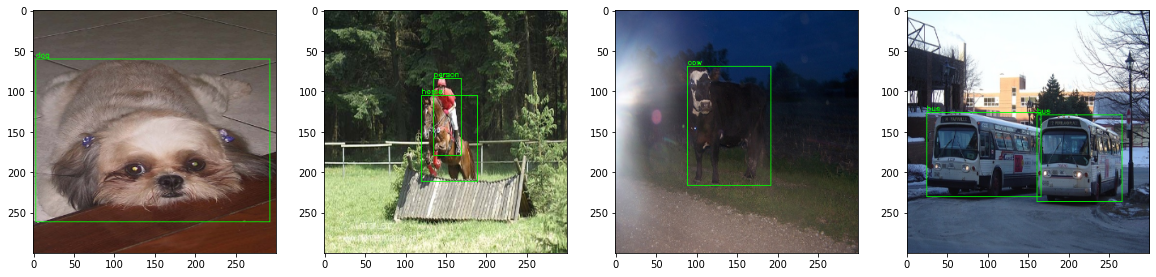

In [ ]:
iterator=iter(voc_dataloader)
for i in range(1):
  try:
    images, gt_labels=next(iterator)
  except StopIteration:
    iterator=iter(voc_dataloader)
    images, gt_labels=next(iterator)
gt_labels=[torch.cat([gt_label[:,:-1]*voc['image_size'], gt_label[:,-1].unsqueeze(1)], axis=1) for gt_label in gt_labels]

class_list=list(voc['classes'].keys())
n_axrows=int(np.ceil(batch_size/5))
n_axcols=min(batch_size, 5)
fig,ax=plt.subplots(nrows=n_axrows, ncols=n_axcols, squeeze=False, figsize=[20,20])
for i in range(n_axcols):
  show_image(ax[0,i], images[i].permute(1,2,0).numpy(), annotations=[gt_labels[i]], colors=[(0,1,0)], class_list=class_list)
plt.show()

## Data augmentations

In [ ]:
# https://github.com/amdegroot/ssd.pytorch/blob/master/utils/augmentations.py

class Compose(object):
  #####################################################################################################################################
  # @ Compose augmentations to be applied sequentially                                                                                #
  # Args:                                                                                                                             #
  # 1. transforms: list of transforms to be applied                                                                                   #
  # Example:                                                                                                                          #
  #   Compose([transform1, transform2, ...])                                                                                          #
  #####################################################################################################################################
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, image, boxes=None, labels=None):
    for transform in self.transforms:
      image, boxes, labels = transform(image, boxes, labels)
    return image, boxes, labels

class ConvertToFloats(object):
  def __call__(self, image, boxes=None, labels=None):
    return image.astype(np.float32), boxes, labels

class SubtractMean(object):
  def __init__(self, mean):
    self.mean = np.array(mean, dtype=np.float32)
  
  def __call__(self, image, boxes=None, labels=None):
    image = image.astype(np.float32)
    image -= self.mean
    return image, boxes, labels

class ToAbsoluteCoords(object):
  def __call__(self, image, boxes=None, labels=None):
    h, w, _=image.shape
    if boxes is not None:
      boxes[:,0] *= w
      boxes[:,1] *= h
      boxes[:,2] *= w
      boxes[:,3] *= h
    return image, boxes, labels

class ToRelativeCoords(object):
  def __call__(self, image, boxes=None, labels=None):
    h, w, _=image.shape
    if boxes is not None:
      boxes[:,0] /= w
      boxes[:,1] /= h
      boxes[:,2] /= w
      boxes[:,3] /= h
    return image, boxes, labels

class Resize(object):
  def __init__(self, size=300):
    self.size = size
  
  def __call__(self, image, boxes=None, labels=None):
    image = cv2.resize(image, (self.size, self.size))
    return image, boxes, labels

class RandomSaturation(object):
  def __init__(self, low=0.5, high=1.5):
    self.low = low
    self.high = high
  
  def __call__(self, image_hsv, boxes=None, labels=None):
    if np.random.randint(2):
      image_hsv[:,:,1] *= np.random.uniform(self.low, self.high)
    return image_hsv, boxes, labels

class RandomHue(object):
  def __init__(self, delta=18.0):
    self.delta = delta

  def __call__(self, image_hsv, boxes=None, labels=None):
    if np.random.randint(2):
      image_hsv[:,:,0] += np.random.uniform(-self.delta, self.delta)
      image_hsv[:,:,0][image_hsv[:,:,0] > 360.0] -= 360.0
      image_hsv[:,:,0][image_hsv[:,:,0] < 0.0] += 360.0
    return image_hsv, boxes, labels

class SwapChannels(object):
  def __init__(self, swaps):
    self.swaps = swaps 
  
  def __call__(self, image):
    image = image[:,:,self.swaps]
    return image

class RandomLightingNoise(object):
  def __init__(self):
    self.perms = ((0,1,2), (0,2,1), (1,0,2), (1,2,0), (2,0,1), (2,1,0))
  
  def __call__(self, image, boxes=None, labels=None):
    if np.random.randint(2):
      swap = self.perms[np.random.randint(len(self.perms))]
      shuffle = SwapChannels(swap)
      image = shuffle(image)
    return image, boxes, labels

class ConvertColorSpace(object):
  def __init__(self, current='RGB', to='HSV'):
    self.current = current
    self.to = to
  
  def __call__(self, image, boxes=None, labels=None):
    if self.current=='RGB' and self.to=='HSV':
      image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif self.current=='HSV' and self.to=='RGB':
      image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    else:
      raise NotImplementedError
    return image, boxes, labels
  
class RandomContrast(object):
  def __init__(self, low=0.5, high=1.5):
    self.low=0.5
    self.high=1.5

  def __call__(self, image, boxes=None, labels=None):
    # input image should be of type floats
    if np.random.randint(2):
      image *= np.random.uniform(self.low, self.high)
    return image, boxes, labels

class RandomBrightness(object):
  def __init__(self, delta=32.0/255.0):
    self.delta = delta
  
  def __call__(self, image, boxes=None, labels=None):
    if np.random.randint(2):
      image += np.random.uniform(-self.delta, self.delta)
    return image, boxes, labels

class ToCV2Image(object):
  def __call__(self, tensor, boxes=None, labels=None):
    return tensor.permute(1,2,0).cpu().numpy().astype(np.float32), boxes, labels

class ToTensor(object):
  def __call__(self, cvimage, boxes=None, labels=None):
    return torch.from_numpy(cvimage.astype(np.float32)).permute(2,0,1), boxes, labels

def intersection_np(boxes1, box2):
  #####################################################################################################################################
  # @ Compute intersection area of each box1 in boxes1 with box2                                                                      #
  # input:                                                                                                                            #
  #   1. boxes1: numpy array of boxes of shape [n_boxes1, 4], each row of form [xmin, ymin, xmax, ymax]                               #
  #   2. box2: target box of shape [4], of form [xmin, ymin, xmax, ymax]                                                              #
  # output:                                                                                                                           #
  #   1. intersection_area: shape [n_boxes1] with intersection_area[i] = intersection area of ith box1 in boxes1 with target box box2 #
  #####################################################################################################################################
  min_xy = np.maximum(boxes1[:,:2], box2[:2])
  max_xy = np.minimum(boxes1[:,2:], box2[2:])
  intersection_ = np.clip((max_xy-min_xy), a_min=0, a_max=np.inf)
  return intersection_[:,0]*intersection_[:,1]

def IOU_np(boxes1, box2):
  intersection_area = intersection_np(boxes1, box2)
  area1 = (boxes1[:,2]-boxes1[:,0])*(boxes1[:,3]-boxes1[:,1])
  area2 = (box2[2]-box2[0])*(box2[3]-box2[1])
  union_area = area1 + area2 - intersection_area
  return intersection_area/union_area

class RandomSampleCrop(object):
  def __init__(self):
    self.sample_options=(
        None, # using entire original image
        (0.1, None), # sample a patch such that min jaccard overlap (IOU) with gt boxes of 0.1
        (0.3, None),
        (0.7, None),
        (0.9, None),
        (None, None) # randomly sample a patch
    )
  
  def __call__(self, image, boxes=None, labels=None):
    if boxes is None:
      return image, boxes, labels

    height, width, _=image.shape
    while True:
      mode = np.random.choice(self.sample_options)
      if mode is None:
        return image, boxes, labels
      min_iou, max_iou=mode
      if min_iou is None:
        min_iou = float('-inf')
      if max_iou is None:
        max_iou = float('inf')

      for _ in range(50):
        current_image = image
        w = np.random.uniform(0.3*width, width)
        h = np.random.uniform(0.3*height, height)

        aspect_ratio=(h/w)
        if (aspect_ratio<0.5) or (aspect_ratio>2):
          continue
        
        left = np.random.uniform(width-w)
        top = np.random.uniform(height-h)
        rect = np.array([int(left), int(top), int(left+w), int(top+h)])
        overlap = IOU_np(boxes, rect)
        if (overlap.min()<min_iou) or (overlap.max()>max_iou):
          continue 
        current_image = current_image[rect[1]:rect[3], rect[0]:rect[2], :]

        centers=(boxes[:,:2]+boxes[:,2:])/2.0
        m1 = (rect[0]<centers[:,0])*(rect[1]<centers[:,1])
        m2 = (rect[2]>centers[:,0])*(rect[3]>centers[:,1])
        mask = m1*m2
        if not mask.any():
          continue
        
        current_boxes = boxes[mask,:].copy()
        current_boxes[:,:2] = np.maximum(current_boxes[:,:2], rect[:2])
        current_boxes[:,:2] -= rect[:2]
        current_boxes[:,2:] = np.minimum(current_boxes[:,2:], rect[2:])
        current_boxes[:,2:] -= rect[:2]
        current_boxes[:,0::2] /= current_image.shape[1]
        current_boxes[:,1::2] /= current_image.shape[0]

        current_labels = labels[mask]
        current_image = cv2.resize(current_image, (300,300))
        current_boxes *= 300
        return current_image, current_boxes, current_labels

      return image, boxes, labels
  
class Expand(object):
  def __init__(self, mean):
    self.mean = mean
  
  def __call__(self, image, boxes, labels):
    if np.random.randint(2): 
      height, width, channels=image.shape
      ratio = np.random.uniform(1,4)
      left = np.random.uniform(0, width*(ratio-1))
      top = np.random.uniform(0, height*(ratio-1))

      expanded_image = np.zeros((int(height*ratio), int(width*ratio), channels), dtype=image.dtype)
      expanded_image[:,:,:] = self.mean 
      expanded_image[int(top):int(top+height), int(left):int(left+widht)] = image 
      image = expanded_image

      boxes[:,:2] += (int(left), int(top))
      boxes[:,2:] += (int(left), int(top))
    return image, boxes, labels

class RandomMirror(object):
  def __call__(self, image, boxes, labels):
    _, width, _=image.shape
    if np.random.randint(2):
      image = np.flip(image, axis=1)
      boxes[:,0::2] = width-boxes[:,2::-2]
    return image, boxes, labels

class PhotometricDistort(object):
  def __init__(self):
    self.distort_transforms = [
                               RandomContrast(),
                               ConvertColorSpace(to='HSV'),
                               RandomSaturation(),
                               RandomHue(),
                               ConvertColorSpace(current='HSV', to='RGB'),
                               RandomContrast()
    ]
    self.rand_brightness = RandomBrightness()
    self.rand_light_noise = RandomLightingNoise()

  def __call__(self, image, boxes, labels):
    image, boxes, labels=self.rand_brightness(image, boxes, labels)
    if np.random.randint(2):
      dist_transforms=Compose(self.distort_transforms[:-1])
    else:
      dist_transforms=Compose(self.distort_transforms[1:])
    image, boxes, labels=dist_transforms(image, boxes, labels)
    # return self.rand_light_noise(image, boxes, labels)
    return image, boxes, labels

In [ ]:
class SSDAugmentation(object):
  def __init__(self, mean=(104.0/255.0, 117.0/255.0, 123.0/255.0)):
    self.mean = mean
    self.augmentations = Compose([
                                  PhotometricDistort(),
                                  RandomSampleCrop(),
                                  RandomMirror(),
                                  SubtractMean(self.mean)
    ])
  
  def __call__(self, image, boxes, labels):
    return self.augmentations(image, boxes, labels)

### Augmentations test

In [ ]:
voc_dataset=VOCDataset(VOC07_BASE_DIR, VOC07_TRAIN_IMAGES_DIR, VOC07_TRAIN_ANNOTATIONS_DIR, image_size=voc['image_size'], transforms=SSDAugmentation())
batch_size=4
voc_dataloader=data.DataLoader(voc_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=voc_batch_collate)

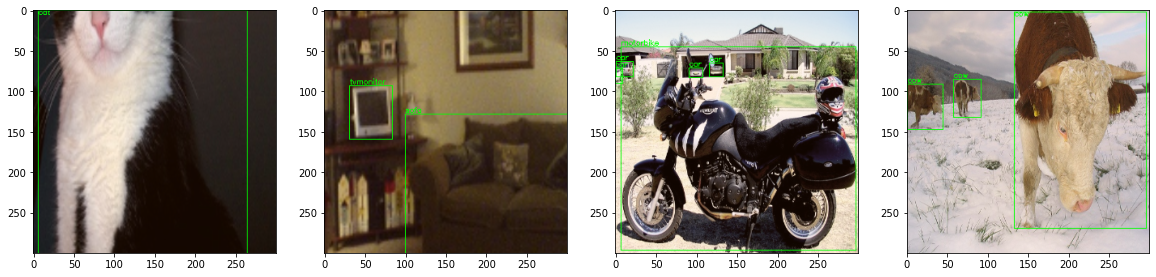

In [ ]:
iterator=iter(voc_dataloader)
for i in range(1):
  try:
    images, gt_labels=next(iterator)
  except StopIteration:
    iterator=iter(voc_dataloader)
    images, gt_labels=next(iterator)
gt_labels=[torch.cat([gt_label[:,:-1]*voc['image_size'], gt_label[:,-1].unsqueeze(1)], axis=1) for gt_label in gt_labels]

class_list=list(voc['classes'].keys())
n_axrows=int(np.ceil(batch_size/5))
n_axcols=min(batch_size, 5)
fig,ax=plt.subplots(nrows=n_axrows, ncols=n_axcols, squeeze=False, figsize=[20,20])
for i in range(n_axcols):
  img=images[i].permute(1,2,0).numpy()
  img=(img-img.min())/(img.max()-img.min())
  show_image(ax[0,i], img, annotations=[gt_labels[i]], colors=[(0,1,0)], class_list=class_list)
plt.show()

# Build SSD network

## Network configuration - Base net, auxiliary layers, prediction layers

In [ ]:
# base network configuration
base_cfg={
    '300': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'C', 512, 512, 512, 'M', 512, 512, 512]
}

# auxiliary layers configuration
auxiliary_cfg={
    '300': [(256,1,1,0), (512,3,2,1), (128,1,1,0), (256,3,2,1), (128,1,1,0), (256,3,1,0), (128,1,1,0), (256,3,1,0)] # (a,b,c,d) => out_channels=a, kernel_size=b, stride=c, padding=d
}

# prediction layers configuration
predictors_cfg={
    '300': [4, 6, 6, 6, 4, 4] # number of default boxes per cell in the corresponding feature map
}

## Module utils

In [ ]:
def vgg(config, in_channels, batch_norm=False):
  #####################################################################################################################################
  # @ vgg base network                                                                                                                #
  # input:                                                                                                                            #
  #   1. config: vgg network config as array of out channels from each layer or layer type                                            #
  #   2. in_channels: input channels to the network                                                                                   #
  #   3: batch_norm: boolean value indicating if batch_norm is on for conv layers                                                     #
  # output:                                                                                                                           #
  #   list of torch.nn modules                                                                                                        #
  #####################################################################################################################################
  layers=[]
  for v in config:
    if v=='M':
      layers+=[nn.MaxPool2d(kernel_size=2, stride=2)]
    elif v=='C':
      layers+=[nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
    else:
      conv2d=nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
      if batch_norm:
        layers+=[conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
      else:
        layers+=[conv2d, nn.ReLU(inplace=True)]
      in_channels=v
  pool5=nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
  conv6=nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
  conv7=nn.Conv2d(1024, 1024, kernel_size=1)
  layers+=[pool5, conv6, nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
  return nn.ModuleList(layers)

def auxiliary_layers(config, in_channels):
  #####################################################################################################################################
  # @ auxiliary layers of the SSD network                                                                                             #
  # input:                                                                                                                            #
  #   1. config: list of values of form (a,b,c,d) such that                                                                           #
  #     a=out_channels from the layer, b=kernel_size, c=stride, d=padding                                                             #
  #   2. in_channels: input number of channels for the first layer                                                                    #
  # output:                                                                                                                           #
  #   list of torch.nn modules in auxiliary layer                                                                                     #
  #####################################################################################################################################
  layers=[]
  for v in config:
    out_channels_, kernel_size_, stride_, padding_=v
    layers+=[nn.Conv2d(in_channels, out_channels_, kernel_size=kernel_size_, stride=stride_, padding=padding_)]
    in_channels=out_channels_
  return nn.ModuleList(layers)

def predictors(base_layers, auxiliary_layers, config, n_classes=21):
  #####################################################################################################################################
  # @ predictor layers which predicts objects (bbox and classes) at multiple scales in the network                                    #
  # return loc_layers (predicting box offsets) and conf_layers (predicting class probabilities) as list of nn.Modules                 #
  # out shape of loc_layers = [n_priors, 4], out shape of conf_layers = [n_priors, n_classes] where n_priors=8732                     #                         
  #####################################################################################################################################
  loc_layers, conf_layers=[],[]
  base_layers_in_use=[21, -2] # layer 22 is ReLU from Conv4_3 in base architecture, so using layer 21 (which is conv2d) to retreive out_channels
  # last layer (-1) is ReLU in base architecture, so using layer -2 (which is conv2d) to retreive out_channels
  for k,v in enumerate(base_layers_in_use):
    loc_layers+=[nn.Conv2d(base_layers[v].out_channels, config[k]*4, kernel_size=3, padding=1)]
    conf_layers+=[nn.Conv2d(base_layers[v].out_channels, config[k]*n_classes, kernel_size=3, padding=1)]
  for k,v in enumerate(auxiliary_layers[1::2], len(base_layers_in_use)):
    loc_layers+=[nn.Conv2d(v.out_channels, config[k]*4, kernel_size=3, padding=1)]
    conf_layers+=[nn.Conv2d(v.out_channels, config[k]*n_classes, kernel_size=3, padding=1)]
  return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)

In [ ]:
class SSD(nn.Module):
  def __init__(self, base_layers, auxiliary_layers, loc_layers, conf_layers, n_classes=21):
    super(SSD, self).__init__()
    self.base_layers=base_layers
    self.auxiliary_layers=auxiliary_layers
    self.loc_layers=loc_layers
    self.conf_layers=conf_layers
    self.n_classes=n_classes
  
  def forward(self, x):
    pred_feature_maps=[]
    # forward pass on base layers till 22 and cache output of layer 22 to use for predictions in pred_feature_maps list
    for k in range(23):
      x=self.base_layers[k](x)
    s=x
    # TO-DO: add L2Norm layer before appending to feature maps list
    pred_feature_maps.append(s)
    # forward pass on remaining layers of base network and cache last layer output to use for predictions in pred_feature_maps list
    for k in range(23, len(self.base_layers)):
      x=self.base_layers[k](x)
    pred_feature_maps.append(x)
    # forward pass on auxiliary layers and cache intermediate layers to be used for prediction in pred_feature_maps list
    for k,v in enumerate(self.auxiliary_layers):
      x=F.relu(v(x), inplace=True)
      if k%2==1:
        pred_feature_maps.append(x)
    # use cached layers for prediction
    loc, conf=[],[]
    for feature_map, loc_layer, conf_layer in zip(pred_feature_maps, self.loc_layers, self.conf_layers):
      loc.append(loc_layer(feature_map).permute(0,2,3,1).contiguous())
      conf.append(conf_layer(feature_map).permute(0,2,3,1).contiguous())
    loc=torch.cat([o.view(o.size(0), -1) for o in loc], 1)
    conf=torch.cat([o.view(o.size(0), -1) for o in conf], 1)
    return loc.view(loc.size(0),-1,4), conf.view(conf.size(0),-1,self.n_classes)

def build_SSD300(base_cfg=base_cfg, auxiliary_cfg=auxiliary_cfg, predictors_cfg=predictors_cfg, base_in_channels=3, aux_in_channels=1024, n_classes=21):
  base_layers=vgg(base_cfg['300'], base_in_channels)
  aux_layers=auxiliary_layers(auxiliary_cfg['300'], aux_in_channels)
  loc_layers, conf_layers=predictors(base_layers, aux_layers, predictors_cfg['300'], n_classes=n_classes)
  ssd300=SSD(base_layers, aux_layers, loc_layers, conf_layers, n_classes=n_classes)
  return ssd300

## Architecture test

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
ssd300=build_SSD300()
ssd300.to(device)
print(ssd300)

SSD(
  (base_layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [ ]:
iterator=iter(voc_dataloader)
for i in range(1):
  try:
    images, gt_labels=next(iterator)
  except StopIteration:
    iterator=iter(voc_dataloader)
    images, gt_labels=next(iterator)
images=images.to(device)
loc_pred, conf_pred=ssd300(images)
print(loc_pred.shape, conf_pred.shape)

torch.Size([4, 8732, 4]) torch.Size([4, 8732, 21])


# Multibox loss

## Box utils

In [ ]:
def to_minmaxformat(boxes_cxcywh):
  #####################################################################################################################################
  # @ convert boxes of form (cx, cy, w, h) to (xmin, ymin, xmax, ymax) form                                                           #
  # input:                                                                                                                            #
  #   1. boxes_cxcywh: tensor of shape [n_boxes, 4], each row of form [cx, cy, w, h]                                                  #
  # output:                                                                                                                           #
  #   2. tensor of shape [n_boxes, 4], each row of form [xmin, ymin, xmax, ymax]                                                      #
  #####################################################################################################################################
  return torch.cat((boxes_cxcywh[:,:2] - boxes_cxcywh[:,2:]/2.0, boxes_cxcywh[:,:2] + boxes_cxcywh[:,2:]/2.0), 1)

def to_cxcywhformat(boxes_minmax):
  #####################################################################################################################################
  # @ convert boxes of form (xmin, ymin, xmax, ymax) to (cx, cy, w, h) form                                                           #
  # input:                                                                                                                            #
  #   1. boxes_minmax: tensor of shape [n_boxes, 4], each row of form [xmin, ymin, xmax, ymax]                                        #
  # output:                                                                                                                           #
  #   2. tensor of shape [n_boxes, 4], each row of form [cx, cy, w, h]                                                                #
  #####################################################################################################################################
  return torch.cat(((boxes_minmax[:,:2] + boxes_minmax[:,2:])/2.0, boxes_minmax[:,2:] - boxes_minmax[:,:2]), 1)

def intersection(boxes1, boxes2):
  #####################################################################################################################################
  # @ compute intersection area of pairs {boxes1[i], boxes2[j]} for all (i,j) pairs                                                   #
  # input:                                                                                                                            #
  #   1. boxes1: tensor of shape [n1, 4] where each row is in form [xmin, ymin, xmax, ymax]                                           #
  #   2. boxes2: tensor of shape [n2, 4] where each row is in form [xmin, ymin, xmax, ymax]                                           #
  # output:                                                                                                                           #
  #   1. intersection area: tensor of shape [n1, n2] where element at (i,j) corresponds to intersection area of boxes1[i], boxes2[j]  #
  #####################################################################################################################################
  n1, n2=boxes1.shape[0], boxes2.shape[0]
  min_xy=torch.max(boxes1[:,:2].unsqueeze(1).expand(n1,n2,2), boxes2[:,:2].unsqueeze(0).expand(n1,n2,2))
  max_xy=torch.min(boxes1[:,2:].unsqueeze(1).expand(n1,n2,2), boxes2[:,2:].unsqueeze(0).expand(n1,n2,2))
  intersection_=torch.clamp((max_xy-min_xy), min=0)
  return intersection_[:,:,0]*intersection_[:,:,1]

def IOU(boxes1, boxes2):
  #####################################################################################################################################
  # @ compute IOU score of pairs {boxes1[i], boxes2[j]} for all (i,j) pairs                                                           #
  # input:                                                                                                                            #
  #   1. boxes1: tensor of shape [n1, 4] where each row is in form [xmin, ymin, xmax, ymax]                                           #
  #   2. boxes2: tensor of shape [n2, 4] where each row is in form [xmin, ymin, xmax, ymax]                                           #
  # output:                                                                                                                           #
  #   1. IOU: tensor of shape [n1, n2] where element at (i,j) corresponds to IOU of boxes1[i], boxes2[j]                              #
  #####################################################################################################################################
  intersection_area=intersection(boxes1, boxes2)
  area1=((boxes1[:,2]-boxes1[:,0])*(boxes1[:,3]-boxes1[:,1])).unsqueeze(1).expand_as(intersection_area)
  area2=((boxes2[:,2]-boxes2[:,0])*(boxes2[:,3]-boxes2[:,1])).unsqueeze(0).expand_as(intersection_area)
  union_area=area1+area2-intersection_area
  return intersection_area/union_area

## Matching strategy for associating ground truth labels to default boxes

In [ ]:
def matching_strategy(gt_labels, default_boxes, overlap_threshold=0.5):
  #####################################################################################################################################
  # @ Associate ground truth labels to default boxes and assign targets for training                                                  #
  # input:                                                                                                                            #
  #   1. gt_labels: ground truth labels - tensor of shape [n_gt, 5]                                                                   #
  #     each row is of form [xmin, ymin, xmax, ymax, class]                                                                           #
  #   2. default_boxes: default boxes - tensor of shape [n_priors, 4] each row in format [xmin, ymin, xmax, ymax]                     #
  #   3. overlap_threshold: minimum IOU between default box and gt box to consider as positve match                                   #
  # output:                                                                                                                           #
  #   1. target_boxes: target box offsets for training - tensor of shape [n_priors, 4], each row in format [xmin, ymin, xmax, ymax]   #
  #   2. target_classes: target classes - tensor of shape [n_priors]                                                                  #
  #     NOTE: 0 for background and actual classes starts with 1                                                                       #
  #####################################################################################################################################
  gt_boxes=gt_labels[:,:-1] # [n_gt, 4]
  gt_classes=gt_labels[:,-1] # [n_gt]
  ious=IOU(gt_boxes, default_boxes) # [n_gt, n_priors]
  best_gt_iou_for_defaultbox, best_gt_id_for_defaultbox=ious.max(0) # [n_priors]
  # best_gt_iou_for_defaultbox[i] = max IOU of the ith default box with all ground truth boxes
  # best_gt_id_for_defaultbox[i] = ID of the ground truth box that has max IOU with the ith default box
  _, best_defaultbox_id_for_gt=ious.max(1) # [n_gt]
  # best_defaultbox_id_for_gt[j] = id of the default box that has max IOU with the jth ground truth box
  n_gt=gt_boxes.size(0)
  # make sure that each gt_box is assigned to a default box
  best_gt_id_for_defaultbox[best_defaultbox_id_for_gt]=torch.LongTensor(range(n_gt))
  best_gt_iou_for_defaultbox[best_defaultbox_id_for_gt]=1.0
  # target boxes
  target_boxes=gt_boxes[best_gt_id_for_defaultbox] # [n_priors, 4]
  # target classes
  target_classes=gt_classes[best_gt_id_for_defaultbox] # [n_priors]
  # label classes as negative/ background if IOU < threshold
  target_classes[best_gt_iou_for_defaultbox < overlap_threshold]=0
  return target_boxes, target_classes

## Encode target boxes as offsets to default boxes

In [ ]:
def encode_targets(target_boxes, default_boxes):
  #####################################################################################################################################
  # @ encode target boxes as offsets to default boxes to make the training process stable                                             #
  # inputs:                                                                                                                           #
  #   1. target_boxes: localization targets in cx-cy-w-h format - tensor of shape [n_priors, 4]                                       #
  #   2. default_boxes: default boxes in cx-cy-w-h format - tensor of shape [n_priors, 4]                                             #
  # output:                                                                                                                           #
  #   1. encoded targets - tensor of shape [n_priors, 4]                                                                              #
  #####################################################################################################################################
  g_cxcy=(target_boxes[:,:2]-default_boxes[:,:2])/default_boxes[:,2:]
  g_wh=torch.log(target_boxes[:,2:]/default_boxes[:,2:])
  return torch.cat((g_cxcy,g_wh), 1)

def decode_offsets(pred_offsets, default_boxes):
  #####################################################################################################################################
  # @ decode predicted offsets to bounding boxes of form [cx, cy, w, h]                                                               #
  # input:                                                                                                                            #
  #   1. pred_offsets: offsets predicted by the network, tensor of shape [n_priors, 4]                                                #
  #   2. default_boxes: default boxes in format cx-cy-w-h, tensor of shape [n_priors, 4]                                              #
  # output:                                                                                                                           #
  #   decoded pred boxes of format cx-cy-w-h, tensor of shape [n_priors, 4]                                                           #
  #####################################################################################################################################
  cxcy=pred_offsets[:,:2]*default_boxes[:,2:] + default_boxes[:,:2]
  wh=default_boxes[:,2:]*torch.exp(pred_offsets[:,2:])
  return torch.cat((cxcy,wh), 1)

## Matching strategy test

In [ ]:
iterator=iter(voc_dataloader)
batch_images, batch_gt_labels=next(iterator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


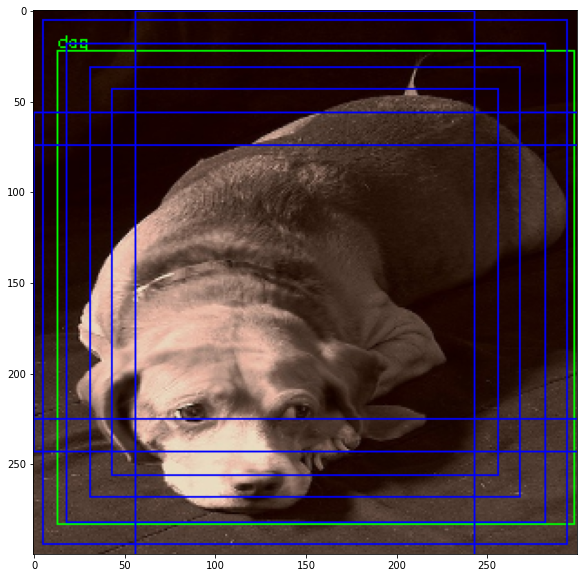

In [ ]:
image, gt_labels=batch_images[0], batch_gt_labels[0]
default_boxes_minmax=to_minmaxformat(default_boxes)
target_boxes, target_classes=matching_strategy(gt_labels, default_boxes_minmax, overlap_threshold=0.5)

gt_labels_scaled=torch.cat([gt_labels[:,:-1]*voc['image_size'], gt_labels[:,-1].unsqueeze(1)], 1)
matched_defaultboxes_scaled=default_boxes_minmax[target_classes>0]*voc['image_size']

class_list=list(voc['classes'].keys())
fig=plt.figure(figsize=[10,10])
ax=plt.subplot(111)
show_image(ax, image.permute(1,2,0).numpy(), annotations=[gt_labels_scaled, matched_defaultboxes_scaled], colors=[(0,255,0), (0,0,255)], class_list=class_list)
plt.show()

## Multibox loss module

In [ ]:
class MultiboxLoss(nn.Module):
  def __init__(self, default_boxes, overlap_threshold=0.5, n_classes=21, alpha=1, neg_pos_ratio=3):
    super(MultiboxLoss, self).__init__()
    self.default_boxes_cxcywh=default_boxes
    self.default_boxes_minmax=to_minmaxformat(self.default_boxes_cxcywh)
    self.overlap_threshold=overlap_threshold
    self.n_classes=n_classes
    self.alpha=alpha
    self.neg_pos_ratio=neg_pos_ratio

  def forward(self, preds, gt_labels):
    pred_offsets, pred_classes=preds
    batch_size=pred_offsets.size(0)
    n_priors=self.default_boxes_cxcywh.size(0)

    target_offsets=torch.Tensor(batch_size, n_priors, 4)
    target_classes=torch.Tensor(batch_size, n_priors)
    for i in range(batch_size):
      target_boxes, target_classes[i]=matching_strategy(gt_labels[i], self.default_boxes_minmax)
      target_boxes=to_cxcywhformat(target_boxes)
      target_offsets[i]=encode_targets(target_boxes, self.default_boxes_cxcywh)
    target_offsets=target_offsets.to(device)
    target_classes=target_classes.to(device)
    
    pos=(target_classes > 0) # positive targets
    n_pos=pos.sum(dim=1, keepdim=True)

    # localization loss
    pos_target_offsets=target_offsets[pos] # positive target offsets
    pos_pred_offsets=pred_offsets[pos] # positive pred offsets
    # localization loss is smooth l1 loss over positve predicted offsets and positive target offsets
    loss_loc=F.smooth_l1_loss(pos_pred_offsets, pos_target_offsets, reduction='sum')

    # classification loss
    # hard negative mining - keeping ratio of negative and positive examples constant
    n_hard_neg=self.neg_pos_ratio*n_pos
    loss_clf_all=F.cross_entropy(pred_classes.view(-1,self.n_classes), target_classes.view(-1).long(), reduction='none') # classification loss for all examples
    loss_clf_all=loss_clf_all.view(batch_size, n_priors)
    loss_clf_pos=loss_clf_all[pos] # classification loss for positive examples

    # retreive hard negatives
    loss_clf_neg=loss_clf_all.clone() # [batch_size, n_priors]
    loss_clf_neg[pos]=0.0
    loss_clf_neg, _=loss_clf_neg.sort(dim=1, descending=True)
    hardness_ranks=torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(loss_clf_neg)
    hard_negatives=(hardness_ranks < n_hard_neg.cpu())
    loss_clf_hard_neg=loss_clf_neg[hard_negatives]

    loss_clf=loss_clf_pos.sum() + loss_clf_hard_neg.sum()

    N=n_pos.sum().float()
    loss_clf /= N
    loss_loc /= N
    loss=loss_clf + self.alpha*loss_loc
    return loss_loc, loss_clf, loss

# Train

In [ ]:
def train(model, dataloader, criterion, optimizer, max_iterations=100, print_step=1, save_step=1):
  loss_loc_hist, loss_clf_hist, loss_hist=[],[],[] # store history of loss values per iteration
  loss_loc_hist_epoch, loss_clf_hist_epoch, loss_hist_epoch=[],[],[] # store history of loss values per epoch
  loss_loc_epoch, loss_clf_epoch, loss_epoch=0.0,0.0,0.0 # loss values per epoch
  n_train_batches=0 # total train batches in an epoch
  # set model in train mode
  model.train()
  iterator=iter(dataloader)
  for i in range(max_iterations):
    t1=time.time()
    try:
      batch_images, batch_gt_labels=next(iterator)
    except StopIteration:
      # dataloader iterator end - indicating epoch end
      loss_loc_hist_epoch.append(loss_loc_epoch/n_train_batches)
      loss_clf_hist_epoch.append(loss_clf_epoch/n_train_batches)
      loss_hist_epoch.append(loss_epoch/n_train_batches)
      loss_loc_epoch, loss_clf_epoch, loss_epoch=0.0,0.0,0.0
      n_train_batches=0
      # reinitialize iterator for next epoch
      iterator=iter(dataloader)
      batch_images, batch_gt_labels=next(iterator)
    batch_images=batch_images.to(device)
    # batch_gt_labels=[gt_label.to(device) for gt_label in batch_gt_labels]

    # forward
    batch_output=model(batch_images)
    # backporp
    optimizer.zero_grad()
    loss_loc, loss_clf, loss=criterion(batch_output, batch_gt_labels)
    loss.backward()
    optimizer.step()
    t2=time.time()

    loss_loc_hist.append(loss_loc.cpu().item())
    loss_clf_hist.append(loss_clf.cpu().item())
    loss_hist.append(loss.cpu().item())
    # accumulate losses per iteration into losses per epoch
    loss_loc_epoch += loss_loc_hist[-1]
    loss_clf_epoch += loss_clf_hist[-1]
    loss_epoch += loss_hist[-1]
    n_train_batches += 1
    print('{0}/{1}: loss_loc={2:.4f}, loss_conf={3:.4f}, loss={4:.4f}, iteration_time={5:.4f}\r'.format(i+1, max_iterations, loss_loc.cpu().item(), loss_clf.cpu().item(), loss.cpu().item(), t2-t1), end='', flush=True)
    if (i+1)%print_step==0:
      print()
    if (i+1)%save_step==0:
      torch.save(model.state_dict(), 'drive/My Drive/Colab/ssd300_'+repr(i+1)+'.pth')
  return loss_loc_hist, loss_clf_hist, loss_hist, loss_loc_hist_epoch, loss_clf_hist_epoch, loss_hist_epoch

## Setup

### Set device

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Set dataset and dataloader

In [ ]:
voc_dataset=VOCDataset(VOC07_BASE_DIR, VOC07_TRAIN_IMAGES_DIR, VOC07_TRAIN_ANNOTATIONS_DIR, image_size=voc['image_size'])
batch_size=32
voc_dataloader=data.DataLoader(voc_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=voc_batch_collate)

### Set loss criterion

In [ ]:
default_boxes_cxcywh=get_default_boxes(voc)
criterion=MultiboxLoss(default_boxes_cxcywh)

### Create model

In [ ]:
ssd300=build_SSD300()

### Initialize weights

In [ ]:
def xavier(param):
  init.xavier_uniform_(param)

def weights_init(module):
  if isinstance(module, nn.Conv2d):
    xavier(module.weight.data)
    module.bias.data.zero_()

#### Training from scratch

In [ ]:
pretrained_vgg_wts_path='drive/My Drive/Colab/vgg16_reducedfc.pth'
vgg_weights=torch.load(pretrained_vgg_wts_path)
ssd300.base_layers.load_state_dict(vgg_weights)

ssd300.auxiliary_layers.apply(weights_init)
ssd300.loc_layers.apply(weights_init)
ssd300.conf_layers.apply(weights_init)

ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

#### Resume training

### Model to GPU

In [ ]:
ssd300.to(device)

SSD(
  (base_layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

### Set optimizer

In [ ]:
optimizer=optim.SGD(ssd300.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)

### Training loop

In [ ]:
max_iterations=20000
print_step=100

In [ ]:
loss_loc_hist, loss_clf_hist, loss_hist=train(ssd300, voc_dataloader, criterion, optimizer, max_iterations, print_step)

100/20000: loss_loc=0.1153, loss_conf=6.2299, loss=6.3452, iteration_time=0.3974
200/20000: loss_loc=0.0850, loss_conf=5.3281, loss=5.4131, iteration_time=0.3884
300/20000: loss_loc=0.0757, loss_conf=5.2134, loss=5.2891, iteration_time=0.3822
400/20000: loss_loc=0.0830, loss_conf=5.2078, loss=5.2908, iteration_time=0.3902
500/20000: loss_loc=0.0782, loss_conf=4.8090, loss=4.8872, iteration_time=0.3881
600/20000: loss_loc=0.0787, loss_conf=4.5907, loss=4.6693, iteration_time=0.3870
700/20000: loss_loc=0.0787, loss_conf=4.8559, loss=4.9346, iteration_time=0.3817
800/20000: loss_loc=0.0856, loss_conf=4.9499, loss=5.0355, iteration_time=0.3903
900/20000: loss_loc=0.0841, loss_conf=4.7549, loss=4.8390, iteration_time=0.3932
1000/20000: loss_loc=0.0809, loss_conf=4.6173, loss=4.6981, iteration_time=0.3830
1100/20000: loss_loc=0.0843, loss_conf=5.1225, loss=5.2068, iteration_time=2.0394
1200/20000: loss_loc=0.0865, loss_conf=4.4217, loss=4.5083, iteration_time=0.3930
1300/20000: loss_loc=0.08

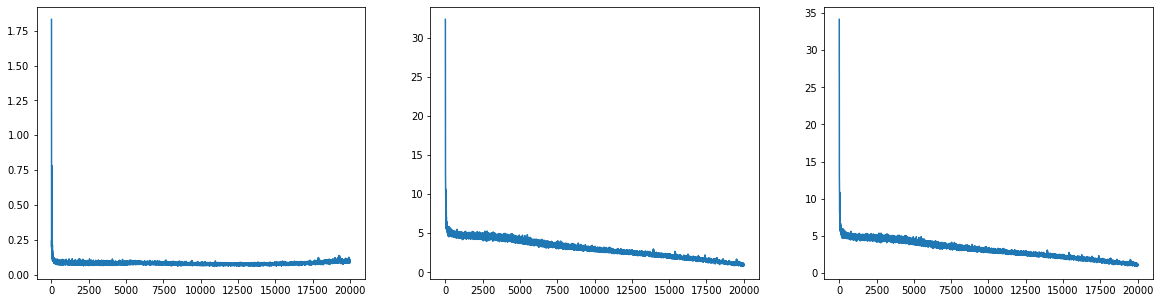

In [ ]:
fig,ax=plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=[20,5])
ax[0,0].plot(range(max_iterations),loss_loc_hist)
ax[0,1].plot(range(max_iterations),loss_clf_hist)
ax[0,2].plot(range(max_iterations),loss_hist)